## To-Do:

## Run on First run only

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
!wget -P ./assets/ https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip ./assets/glove.6B.zip -d ./assets/

## Imports

In [1]:
display_width = 100 # in percentage

from IPython.display import display, HTML
display(HTML("<style>.container { width:"+str(display_width)+"% !important; }</style>"))

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages")

In [4]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from EDA import EDA_movie_reviews
from preprocessing import preprocMovieReview
from feature_extraction import textVectorizer, GloveVectorizer
from utils import train_val_test_split, compare_performances_across_classifiers
from classification import LogisticRegressionClf, BiLSTMClf, DistilBERTClassifier

2023-09-03 18:23:43.239935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 18:23:44.185844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-03 18:23:44.185930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-03 18:23:44.185938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Read Data

In [6]:
df_movie_reviews = pd.read_csv("./data/movie_review_train.tsv", delimiter="\t")
df_movie_reviews.sample(10)

,id,sentiment,review
18526,10660_1,0,I pity people calling kamal hassan 'ulaganaaya...
10598,3200_10,1,This is a great Canadian comedy series. The mo...
21210,5451_8,1,"I'd love to give this movie a 10/10, but in it..."
24831,10692_8,1,"Good, funny, straightforward story, excellent ..."
13,7369_1,0,"I had a feeling that after \Submerged\"", this ..."
6279,9632_1,0,I have an awful pan-and-scan videotape of \Boo...
14338,6528_4,0,Very bad but watchable science fiction film th...
19666,8331_4,0,"What an unfortunate mess is \Shiner.\"" I wante..."
22048,10429_10,1,I'm not usually a fan of strictly romantic mov...
12558,8173_8,1,The brilliance of this movie is that even a co...


## Basic Text Preprocessing

Removes special characters, tokenizes, removes stopwords and strips whitespace 

In [7]:
text_preprocessor = preprocMovieReview(df_movie_reviews['review'])
df_movie_reviews['review_clean'] = text_preprocessor.basic_text_sanitization_pipeline()

/home/sgupta/algorithms/cp_new/cluepoints-case/preprocessing.py:96: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  html_parser = BeautifulSoup(review_text, "html.parser")


In [8]:
df_movie_reviews['review_clean'].sample(3).values

array(['noted reviewers one best tarzan movies unlike others however like beginning film feels like pretty accurate depiction trading post must like plus exposition needed know harry wants go back jungle addition beginning film contains one thrilling terrifying chase sequences ever made occurs harry safari group outrun tribe cannibals pre censorship production values add lot realism genuinely depicting terrible dangers awaited europeans going jungle film also offers though perhaps antecedently accurate account horribly treated native africans white employers addition sexy jane thousands elephants great sets two chetas missed adventure classic',
       'gorging variety seemingly immature movies purchased ex rental dvds figured time right little serious drama better provide sam mendes number reasons american beauty appeal much film easily darkest thing tom hanks ever done probably one underrated films last decade simple gangster tale lifted graphic novel origins simply wonderful watch de

# Exploratory Data Analysis

In [9]:
eda = EDA_movie_reviews(df_movie_reviews, reviews_col='review_clean', target_col='sentiment')

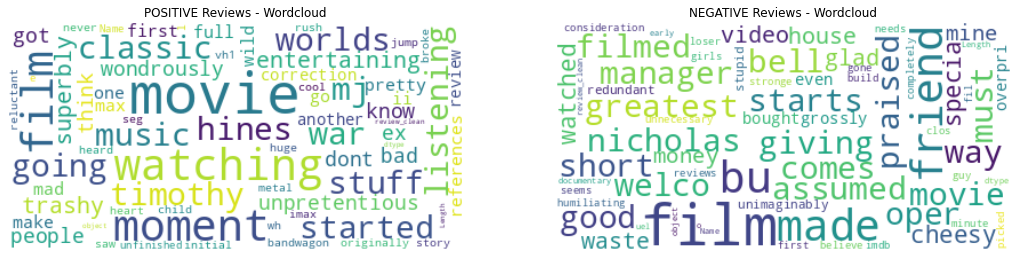

In [10]:
eda.visualize_wordcloud()

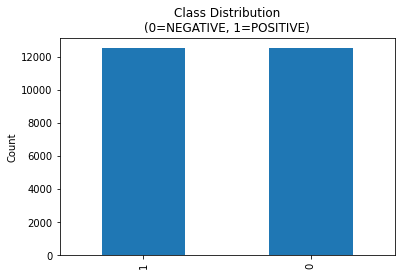

In [11]:
eda.visulaize_class_distribution()

In [12]:
eda.statistics_on_review_text()

Statistics on count of tokens per POSITIVE movie review


count    12500.000000
mean       123.490880
std         95.872217
min          7.000000
5%          31.000000
10%         44.000000
25%         63.750000
50%         90.000000
75%        152.000000
90%        251.000000
95%        325.000000
max       1429.000000
Name: n_tokens, dtype: float64

Statistics on count of tokens per NEGATIVE movie review


count    12500.000000
mean       118.570880
std         86.895436
min          4.000000
5%          35.000000
10%         49.000000
25%         65.000000
50%         89.000000
75%        143.000000
90%        229.100000
95%        297.000000
max        822.000000
Name: n_tokens, dtype: float64

***Conclusions***

1. **max_sequence_length of 150 will cover 75% of the sentences.**
2. **max_sequence_length of 300 will cover 95% of the sentences.**

In [13]:
eda.show_common_n_grams(n=3, show_count=20)

--------------------------------------------------
most common 3-grams for POSITIVE:
--------------------------------------------------
n_grams -- occurence_counts
('new', 'york', 'city') -- 115
('one', 'best', 'movies') -- 77
('world', 'war', 'ii') -- 72
('one', 'best', 'films') -- 63
('first', 'time', 'saw') -- 59
('movies', 'ever', 'seen') -- 56
('movie', 'ever', 'seen') -- 55
('rock', 'n', 'roll') -- 54
('based', 'true', 'story') -- 53
('first', 'saw', 'movie') -- 50
('well', 'worth', 'watching') -- 50
('films', 'ever', 'made') -- 46
('william', 'h', 'macy') -- 46
('would', 'love', 'see') -- 45
('40', 'year', 'old') -- 41
('daniel', 'day', 'lewis') -- 41
('movies', 'ever', 'made') -- 41
('highly', 'recommend', 'movie') -- 40
('best', 'movie', 'ever') -- 39
('international', 'film', 'festival') -- 38
--------------------------------------------------
most common 3-grams for NEGATIVE:
--------------------------------------------------
n_grams -- occurence_counts
('worst', 'movie', 'e

Initialize Dataframe to Store Classification Metrics

In [14]:
df_metrics = pd.DataFrame()

# Establish Baseline: TFIDF Vectorizer + Basic Classifier

TFIDF is a common vectorizer that takes into account only word counts. It does not model any kind of semantic similarity between words, but for basic classification tasks this can be good. It may suffer in cases such as when sarcasm in indicated. The Classifier used with TFIDF is Logistic Regression due to the simplicity in its implementation to establish a baseline performance.

In [15]:
(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    X_val, 
    y_val
) = train_val_test_split(
    df_movie_reviews, 
    feature_cols='review_clean', 
    target_col='sentiment',
    test_percent=25, 
)

print(f"{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}, {X_val.shape}, {y_val.shape}")

(18750,), (18750,), (6250,), (6250,), (0,), (0,)


In [16]:
tfidf_vectorizer = textVectorizer(vectorizer_type='tfidf')
X_train_tfidf = tfidf_vectorizer.apply_transform_train(X_train)
X_test_tfidf = tfidf_vectorizer.apply_transform_test(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)

(18750, 10000) (6250, 10000)


In [17]:
clf_logistic_regression = LogisticRegressionClf()
clf_logistic_regression.fit_classifier(X_train_tfidf, y_train)

In [18]:
y_pred = clf_logistic_regression.predict_classifier(X_test_tfidf)
precision_lr, recall_lr, f1_lr, accuracy_lr = clf_logistic_regression.evaluate_classifier(y_test, y_pred)

In [19]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "logistic_regression",
        "precision": precision_lr,
        "recall": recall_lr,
        "f1": f1_lr,
        "accuracy": accuracy_lr,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.885723,0.900669,0.893133,0.89168


# Improved Classifier: TFIDF Vectorizer + BiLSTM

An improved BiLSTM classifier is is used in an attempt to improve model performance. BiLSTMs are adept at comprehending contextual nuances through bidirectional text processing, taking into account both preceding and succeeding words. This capability makes it suitable for capturing the intricacies of sentiment within sentences. Furthermore, BiLSTMs are capable of capturing dependencies between words, which is essential for understanding the sentiment of complex sentences where the sentiment may change or be influenced by distant words.

In [20]:
(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    X_val, 
    y_val
) = train_val_test_split(
    df_movie_reviews, 
    feature_cols='review_clean', 
    target_col='sentiment',
    test_percent=15, 
    val_percent=15,
)

print(f"{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}, {X_val.shape}, {y_val.shape}")

(17500,), (17500,), (3750,), (3750,), (3750,), (3750,)


In [21]:
embedding_dim = 1
vocab_size = 1000 # making this smaller to speed up training
max_sequence_length = vocab_size

In [22]:
tfidf_vectorizer = textVectorizer(vectorizer_type='tfidf', vocab_size=vocab_size)
X_train_tfidf = tfidf_vectorizer.apply_transform_train(X_train).toarray().reshape(-1, len(X_train), vocab_size).transpose(1, 2, 0)
X_test_tfidf = tfidf_vectorizer.apply_transform_test(X_test).toarray().reshape(-1, len(X_test), vocab_size).transpose(1, 2, 0)
X_val_tfidf = tfidf_vectorizer.apply_transform_test(X_val).toarray().reshape(-1, len(X_val), vocab_size).transpose(1, 2, 0)

print(X_train_tfidf.shape, X_test_tfidf.shape, X_val_tfidf.shape)

(17500, 1000, 1) (3750, 1000, 1) (3750, 1000, 1)


2023-09-03 18:25:34.806956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-03 18:25:34.806990: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-03 18:25:34.807012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (otamatone): /proc/driver/nvidia/version does not exist
2023-09-03 18:25:34.807254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1000, 128)        33792     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 42,113
Trainable params: 42,113
Non-traina

INFO:tensorflow:Assets written to: ./assets/20230903183149_BiLSTM_classifier/assets


INFO:tensorflow:Assets written to: ./assets/20230903183149_BiLSTM_classifier/assets


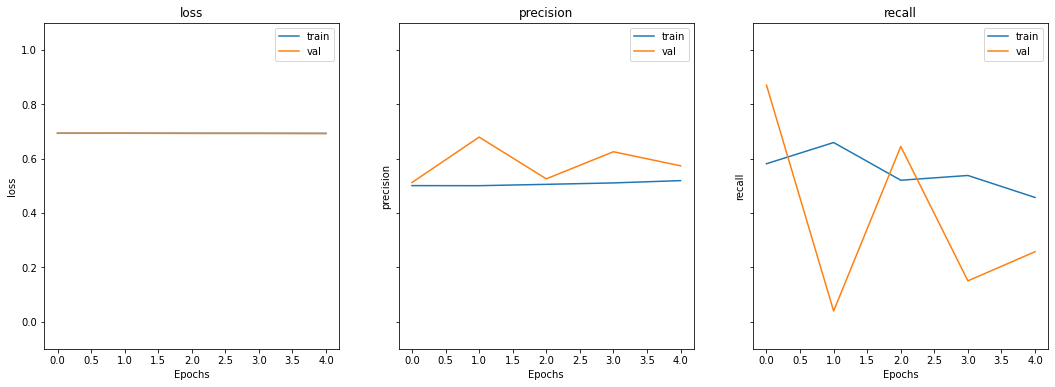

In [23]:
HIDDEN_ACTIVATION = 'relu'
MAX_EPOCHS = 5
LR_INIT = 1e-3
BATCH_SIZE = 256
L2_REG_PENALTY = 1e-3
CALLBACKS = ["es", "rlrop", "tensorboard"]
VERBOSITY_LEVEL = 2
SAVE_DIR = "./assets/"

clf_bilstm = BiLSTMClf(
        embedding_dim,
        vocab_size,
        max_sequence_length,
        HIDDEN_ACTIVATION,
        MAX_EPOCHS,
        LR_INIT,
        BATCH_SIZE,
        L2_REG_PENALTY,
        CALLBACKS,
        VERBOSITY_LEVEL,
        SAVE_DIR,
)

clf_bilstm.fit_classifier(X_train_tfidf, y_train, X_val_tfidf, y_val)

In [24]:
y_pred = clf_bilstm.predict_classifier(X_test_tfidf)
precision_bilstm_tfidf, recall_bilstm_tfidf, f1_bilstm_tfidf, accuracy_bilstm_tfidf = clf_bilstm.evaluate_classifier(y_test, y_pred)

118/118 [==============================] - 16s 137ms/step


In [25]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "bilstm_tfidf",
        "precision": precision_bilstm_tfidf,
        "recall": recall_bilstm_tfidf,
        "f1": f1_bilstm_tfidf,
        "accuracy": accuracy_bilstm_tfidf,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.885723,0.900669,0.893133,0.891680
0,bilstm_tfidf,0.536817,0.243797,0.335312,0.522133


# Improved Embeddings: GloVe + BiLSTM

Pre-trained GloVe word embeddings provide a way to initialize the model with rich semantic representations of words. This helps the model understand the meaning of words and their relationships, even with limited training data. Using pre-trained embeddings like GloVe can significantly reduce the need for large amounts of labeled data, as in the case of this problem. The model can leverage the knowledge encoded in GloVe embeddings and fine-tune its parameters on this specific task.

In [26]:
(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    X_val, 
    y_val
) = train_val_test_split(
    df_movie_reviews, 
    feature_cols='review_clean', 
    target_col='sentiment',
    test_percent=15, 
    val_percent=15,
)

print(f"{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}, {X_val.shape}, {y_val.shape}")

(17500,), (17500,), (3750,), (3750,), (3750,), (3750,)


In [27]:
embedding_dim = 50
vocab_size = 100_000
max_sequence_length = 300
glove_emb_path = f"./assets/glove.6B.{embedding_dim}d.txt"

In [28]:
glove_vectorizer = GloveVectorizer(embedding_dim, vocab_size, max_sequence_length, glove_emb_path)

X_train_glove = glove_vectorizer.vectorize_text(X_train)
X_test_glove = glove_vectorizer.vectorize_text(X_test)
X_val_glove = glove_vectorizer.vectorize_text(X_val)

print(X_train_glove.shape, X_test_glove.shape, X_val_glove.shape)

(17500, 300, 50) (3750, 300, 50) (3750, 300, 50)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 300, 128)         58880     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 67,201
Trainable params: 67,201
Non-trai

INFO:tensorflow:Assets written to: ./assets/20230903183430_BiLSTM_classifier/assets


INFO:tensorflow:Assets written to: ./assets/20230903183430_BiLSTM_classifier/assets


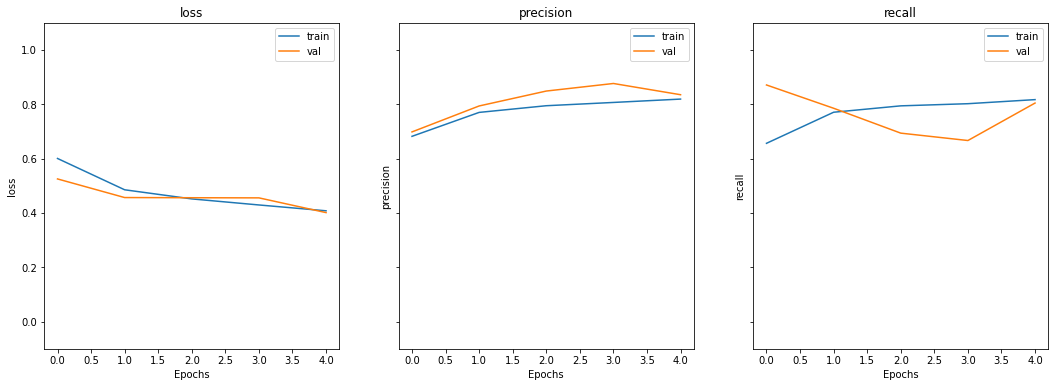

In [29]:
HIDDEN_ACTIVATION = 'relu'
MAX_EPOCHS = 5
LR_INIT = 1e-3
BATCH_SIZE = 256
L2_REG_PENALTY = 1e-3
CALLBACKS = ["es", "rlrop", "tensorboard"]
VERBOSITY_LEVEL = 2
SAVE_DIR = "./assets/"

clf_bilstm_glove = BiLSTMClf(
    embedding_dim,
        vocab_size,
        max_sequence_length,
        HIDDEN_ACTIVATION,
        MAX_EPOCHS,
        LR_INIT,
        BATCH_SIZE,
        L2_REG_PENALTY,
        CALLBACKS,
        VERBOSITY_LEVEL,
        SAVE_DIR,
)

clf_bilstm_glove.fit_classifier(X_train_glove, y_train, X_val_glove, y_val)

In [30]:
y_pred = clf_bilstm_glove.predict_classifier(X_test_glove)
precision_bilstm_glove, recall_bilstm_glove, f1_bilstm_glove, accuracy_bilstm_glove = clf_bilstm_glove.evaluate_classifier(y_test, y_pred)

118/118 [==============================] - 5s 43ms/step


In [31]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "bilstm_glove",
        "precision": precision_bilstm_glove,
        "recall": recall_bilstm_glove,
        "f1": f1_bilstm_glove,
        "accuracy": accuracy_bilstm_glove,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.885723,0.900669,0.893133,0.891680
0,bilstm_tfidf,0.536817,0.243797,0.335312,0.522133
0,bilstm_glove,0.830250,0.805702,0.817792,0.818667


# Improved Embeddings and Classifier: DistilBERT Classifier

BERT is used as in improvement over BiLSTM+GloVe in this final section because, it is a pre-trained transformer-based model that comes with pre-learned contextual word representations. It eliminates the need for manual feature engineering and complex architectures like BiLSTMs. BERT can be fine-tuned for sentiment analysis with minimal effort. Here, DistilBERT is used instead of BERT because DistilBERT offers similar performance to BERT but with reduced computational complexity and memory requirements, making it a more efficient choice for many NLP tasks. DistilBERT simplifies sentiment classification, offers excellent performance, and is computationally efficient (if you have nice GPU only :p), making it a great choice for this task. 

**Improvement Idea:** use DistilBERT trained on rotten tomatoes sentiment classification dataset for transfer learning

**NOTE:** training over small nb of samples in interest of time

In [32]:
(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    X_val, 
    y_val
) = train_val_test_split(
    df_movie_reviews, 
    feature_cols='review_clean', 
    target_col='sentiment',
    test_percent=15, 
    val_percent=15,
)

print(f"{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}, {X_val.shape}, {y_val.shape}")

(17500,), (17500,), (3750,), (3750,), (3750,), (3750,)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

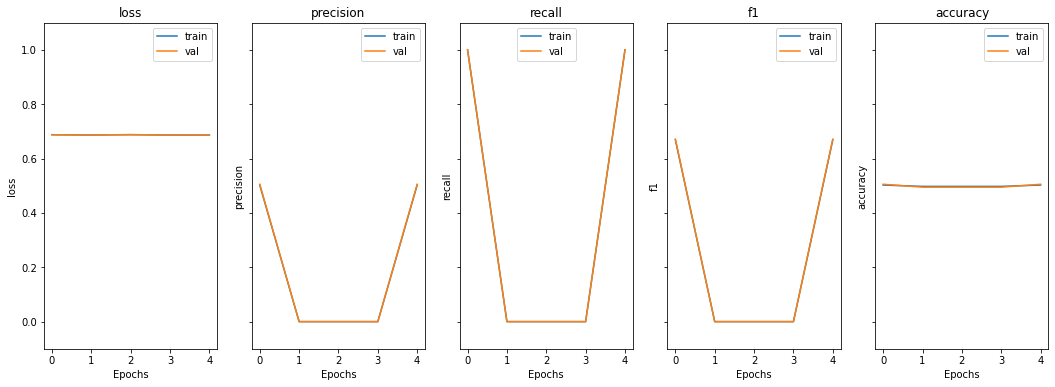

Model Saved at: ./assets/20230903192412_DistilBERT_classifier


In [34]:
BATCH_SIZE = 32
N_EPOCHS = 5
MAX_SEQUENCE_LEN = 150
SAVE_DIR = "./assets/"

clf_distilbert = DistilBERTClassifier()
# training over small nb of samples in interest of time
clf_distilbert.fit_classifier(
    X_train[:BATCH_SIZE*100], y_train[:BATCH_SIZE*100], 
    X_val[:BATCH_SIZE*100], y_val[:BATCH_SIZE*100], 
    batch_size=BATCH_SIZE, n_epochs=N_EPOCHS,
    max_sequence_len=MAX_SEQUENCE_LEN,
    SAVE_DIR=SAVE_DIR,
)

In [35]:
y_pred = clf_distilbert.predict_classifier(X_test)
precision_distilbert, recall_distilbert, f1_distilbert, accuracy_distilbert = clf_distilbert.evaluate_classifier(y_test, y_pred)

In [36]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "distilbert",
        "precision": precision_distilbert,
        "recall": recall_distilbert,
        "f1": f1_distilbert,
        "accuracy": accuracy_distilbert,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.885723,0.900669,0.893133,0.891680
0,bilstm_tfidf,0.536817,0.243797,0.335312,0.522133
0,bilstm_glove,0.830250,0.805702,0.817792,0.818667
0,distilbert,0.494933,1.000000,0.662148,0.494933


### Clear GPU Memory if needed

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Compare Classifiers

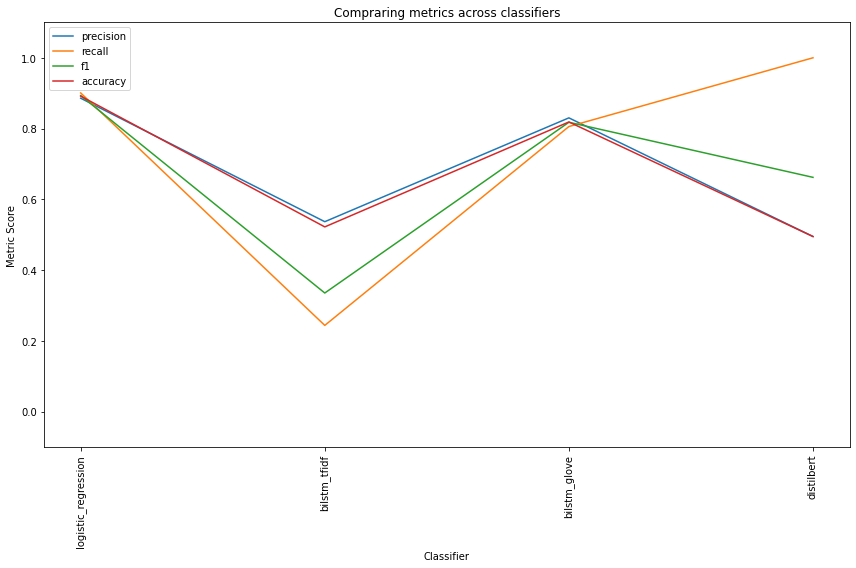

In [37]:
compare_performances_across_classifiers(df_metrics)

In [39]:
display(df_metrics)

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.885723,0.900669,0.893133,0.891680
1,bilstm_tfidf,0.536817,0.243797,0.335312,0.522133
2,bilstm_glove,0.830250,0.805702,0.817792,0.818667
3,distilbert,0.494933,1.000000,0.662148,0.494933


**Discussion:**

This problem is a balanced binary classification problem and the results of comparing classifier performances are in line with expectations (mostly).

Logistic regression outperforms all other models. Although expected to be performant, given the simplicity of the task and the limited dataset size, it being the best performing model was not highly expected, but not a big surprise.

BiLSTM with tfidf uses vectors which have low dimensionality due to computational constraints. as a result, the performance drop can be seen. If trained with higher dimensional vectors, it is expected to perform better, but maybe still may not reach the performance the logistic regression classifier 

The performance of BiLSTM with GloVe is quite high and at the expect levels for this problem. The inclusion of semantic meaning proves to be a valuable addition in better understanding the relationship between words.

For training DistilBERT, much more computational resources are needed as is evident from its performance. Theoretically, the most power model in this comparison, its performance fails to show its abilities in this comparison. The main reasons for this are the small subset of the training data this model was trained on. With the full training set and more epochs of training, this model has the potential to be the best performing model in this comparison.

A bias in this evaluation is that the train test split was performed independently for each configuration. As a result the comparisons are not exactly the same. However, the differences are expected to be not significant.